In [1]:
import os
from datasets import load_dataset, concatenate_datasets
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from keras.initializers import Constant
from keras.models import Sequential
from keras.utils import plot_model
from keras.layers import Dense, Embedding, Dropout, Flatten, Conv1D, GlobalMaxPooling1D, MaxPooling1D, Embedding
from sklearn.metrics import confusion_matrix
from keras_preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from keras_preprocessing.text import Tokenizer
from matplotlib.pyplot import figure
import tensorflow.keras.backend as K

import seaborn as sn
import pandas as pd
import numpy as np
import string
import re
import tensorflow as tf
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Samu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Samu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Samu\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Samu\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
%pip list

Package                      Version
---------------------------- --------------
absl-py                      2.1.0
aiohttp                      3.9.3
aiosignal                    1.3.1
anyio                        4.3.0
argon2-cffi                  23.1.0
argon2-cffi-bindings         21.2.0
arrow                        1.3.0
asttokens                    2.4.1
astunparse                   1.6.3
async-lru                    2.0.4
async-timeout                4.0.3
attrs                        23.2.0
Babel                        2.14.0
beautifulsoup4               4.12.3
bleach                       6.1.0
cachetools                   5.3.3
certifi                      2024.2.2
cffi                         1.16.0
charset-normalizer           3.3.2
click                        8.1.7
colorama                     0.4.6
comm                         0.2.2
contourpy                    1.2.0
cycler                       0.12.1
datasets                     2.18.0
debugpy                      1.8.

In [3]:
import tensorflow as tf
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

We will try different strategies:

Strategy 1:
- Tokenization
- To lowercase
- Glove

Strategy 2:
- Tokenization
- Punctuation removal
- Stop words removal
- To lowercase
- Glove

Strategy 3:
- Tokenization
- Punctuation removal
- Stop words removal
- Lemmatization
- To lowercase
- Glove

Strategy 4:
- Tokenization
- Punctuation removal
- Stop words removal
- Stemming
- To lowercase
- Glove

Strategy 5:
- Tokenization
- Punctuation removal
- Stop words removal
- Stemming
- Lemmatization
- To lowercase
- Glove

In [4]:
from tensorflow.python.client import device_lib

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print(get_available_devices())

['/device:CPU:0', '/device:GPU:0']


https://www.analyticsvidhya.com/blog/2021/09/sentiment-classification-using-nlp-with-text-analytics/ -> Sentiment classification using nlp text analytics

- Text preprocessing:
    * stemming
    * lemmatization
- Models:
    * Naive Bayes
    * TF-IDF vectorizer
    * Networks:
        ...






In [5]:
dataset = load_dataset("Annanay/aml_song_lyrics_balanced")

In [6]:
# Embedding using GloVe

# Tokenization
# NLTK work_tokenize: divide sentences into words
# Punctuation and Stop words removed
# Lemmatization -> reduce words to lemmas
# Stemming -> shorten words by removing morphological affixes to retain only the word stems. ->NOT GOOD
# Converting words into feature vectors 
# TfidfTransformer to transform the count matrix into a normalized TF (Term frequency) or TF-IDF (Term frequence-Inverse Document Frequency) representation.

In [7]:
dataset['train'][0]

{'Unnamed: 0': 0,
 'lyrics_filename': 'Five_Finger_Death_Punch___Bulletproof',
 'mood': 'anger',
 'lyrics': '"Bulletproof Lyrics[Verse 1]\\nYou can take money\\nYou can take the ride\\nYou can take it all but never get inside\\nYou can\'t take my honor\\nYou can\'t take my soul\\nYou can\'t take the fact you\'ll never have control\\n\\n[Pre-Chorus]\\nYou won\'t break me\\nNo matter how hard you try\\nYou can\'t shake me down\\nI\'m fucking bulletproof\\n[Chorus]\\nAll I\'ve learned, it\'s like poison\\nAll I\'ve known, inside my veins\\nAll I\'ve seen, it\'s like venom\\nAll I know, it\'s all that remains\\n\\n[Verse 2]\\nYou can keep the fortune\\nYou can have the fame\\nYou can have the shit you never will obtain\\nYou can\'t take my virtue\\nYou can\'t take my pride\\nYou can\'t take the anger building up inside\\n\\n[Pre-Chorus]\\nYou won\'t break me\\nNo matter how hard you try\\nYou can\'t shake me down\\nI\'m fucking bulletproof\\n\\n[Chorus]\\nAll I\'ve learned, it\'s like pois

In [8]:
filename = '../datasets/Lyrics_dataset/glove.6B.100d.txt'

# Create dictionary of words embeddings
# This words embeddings are word representations in a vectorial space
# The vectors used for this project are the "Globol Vectors for Word Representation (Glove)"
# The size of the vectors is 100
file = open(filename, encoding = "utf-8")
embed_DB = {}
for a_line in file:
    embedding = a_line.split()
    the_word = embedding[0]
    context_array = embedding[1:]
    embed_DB[the_word] = np.asarray(context_array)
file.close()

In [9]:
def get_wordnet_pos(treebank_tag):
        """
        return WORDNET POS compliance to WORDENT lemmatization (a,n,r,v) 
        """
        if treebank_tag.startswith('J'):
            return 'a'
        elif treebank_tag.startswith('V'):
            return 'v'
        elif treebank_tag.startswith('N'):
            return 'n'
        elif treebank_tag.startswith('R'):
            return 'r'
        else:
            return 'n'

In [47]:
def process_data(lyrics, stopwords, punctuation, lemmatize, stemmer):
    # Remove jump lines and song structure text "[]"
    lyrics_clean = []
    translator = str.maketrans('', '', string.punctuation)

    for lyric in lyrics:
        # Remove newlines and tags like [Verse], [Chorus], etc.
        cleaned_text = re.sub(r"\\n", " ", lyric)
        cleaned_text = re.sub(r"\[\w+.*?\]", "", cleaned_text)
        if punctuation:
            cleaned_text = cleaned_text.translate(translator)
        lyrics_clean.append(cleaned_text)

    # Separates a text into a list of tokens/words
    lyrics_tokens = []
    for lyric in lyrics_clean:
        tokens = word_tokenize(lyric) 
        lyrics_tokens.append(tokens)

    # Remove stopwords if necessary
    if stopwords:
        stopwords=nltk.corpus.stopwords.words('english') + ['@']
        no_stopwords_data = []

        for lyric in lyrics_tokens:
            temp = [word for word in lyric if not word in stopwords]
            no_stopwords_data.append(temp) 

        lyrics_tokens = no_stopwords_data

    # Remove stems from word lyrics
    if stemmer:
        stemmer = nltk.stem.LancasterStemmer()    
        X_stemmed = []

        for sentence in lyrics_tokens:
            temp = [stemmer.stem(word) for word in sentence]
            X_stemmed.append(temp)

    # Lemmatize the lyrics
    if lemmatize:
        lemmatizer = nltk.stem.WordNetLemmatizer()

        X_pos = []
        X_lemmatized = []

        for lyric in lyrics_tokens:
            temp = nltk.pos_tag(lyric) # Part of speech tagger
            X_pos.append(temp)
            
        for lyric in X_pos :
            temp = [ lemmatizer.lemmatize(word[0],pos=get_wordnet_pos(word[1])) for word in lyric]
            X_lemmatized.append(temp)  

        lyrics_tokens = X_lemmatized 

    # Transforms words to a sequence of numbers
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lyrics_tokens) # Updates vocabulary
    lyrics_sequence = tokenizer.texts_to_sequences(lyrics_tokens) 

    # Creates sparse matrix so every entry has the same dimensions
    highest_tokens = max([len(tokenized_lyric) for tokenized_lyric in lyrics_tokens]) # Number of maximum words
    lyrics_matrix = pad_sequences(lyrics_sequence, maxlen=highest_tokens) 

    # Making embedding matrix
    word_index = tokenizer.word_index
    total_words = len(word_index) + 1
    embed_mat = np.zeros((total_words, 100))
    
    for word, index in word_index.items():
        if index > total_words:
            continue
        embed_vec = embed_DB.get(word)
        # edge cases
        if embed_vec is None:
            continue
        embed_mat[index] = embed_vec
    
    return embed_mat, lyrics_matrix, total_words, highest_tokens, tokenizer

In [48]:
# Strat 1
train_data, train_mat, total_words1, highest_tokens1, tokenizer1 = process_data(dataset['train']['lyrics'], stopwords=False, punctuation=False, lemmatize=False, stemmer=False)
test_data, test_mat, total_words_test1, highest_tokens_test1, tokenizer1 = process_data(dataset['test']['lyrics'], stopwords=False, punctuation=False, lemmatize=False, stemmer=False)

In [12]:
# Strat 2
# train_data2, train_mat2, total_words2, highest_tokens2 = process_data(dataset['train']['lyrics'], stopwords=True, punctuation=True, lemmatize=False, stemmer=False)
# test_data2, test_mat2, total_words_test2, highest_tokens_test2 = process_data(dataset['train']['lyrics'], stopwords=True, punctuation=True, lemmatize=False, stemmer=False)

In [13]:
# Strat 3
# train_data3, train_mat3, total_words3, highest_tokens3 = process_data(dataset['train']['lyrics'], stopwords=True, punctuation=True, lemmatize=True, stemmer=False)
# test_data3, test_mat3, total_words_train3, highest_tokens_train3 = process_data(dataset['train']['lyrics'], stopwords=True, punctuation=True, lemmatize=True, stemmer=False)

In [14]:
# Strat 4
# train_data4, train_mat4, total_words4, highest_tokens4 = process_data(dataset['train']['lyrics'], stopwords=True, punctuation=True, lemmatize=False, stemmer=True)
# test_data4, test_mat4, total_words_test4, highest_tokens_test4 = process_data(dataset['train']['lyrics'], stopwords=True, punctuation=True, lemmatize=False, stemmer=True)

In [15]:
# Strat 5
# train_data5, train_mat5, total_words5, highest_tokens5 = process_data(dataset['train']['lyrics'], stopwords=True, punctuation=True, lemmatize=True, stemmer=True)
# test_data5, test_mat5, total_words_test5, highest_tokens_test5 = process_data(dataset['train']['lyrics'], stopwords=True, punctuation=True, lemmatize=True, stemmer=True)

In [16]:
# Compare the number of words and other parameters that are generated for each 

In [17]:
################################################################################################################################
# TF

In [18]:
def recall_m(y_true, y_pred):
    y_true_int = K.cast(y_true, 'float32')  # Cast y_true to float32
    y_pred_int = K.cast(y_pred, 'float32')  # Cast y_true to float32
    
    true_positives = y_true_int * y_pred_int
    possible_positives = K.sum(K.round(K.clip(y_true_int, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    y_true_int = K.cast(y_true, 'float32')  # Cast y_true to float32
    y_pred_int = K.cast(y_pred, 'float32')  # Cast y_true to float32

    true_positives = K.sum(K.round(K.clip(y_true_int * y_pred_int, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    y_true_int = K.cast(y_true, 'float32')  # Cast y_true to float32
    y_pred_int = K.cast(y_pred, 'float32')  # Cast y_true to float32
    
    precision = precision_m(y_true_int, y_pred_int)
    recall = recall_m(y_true_int, y_pred_int)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [19]:
# lyrics_clean = []
# translator = str.maketrans('', '', string.punctuation)

# for lyric in dataset['train']['lyrics']:
#     # Remove newlines and tags like [Verse], [Chorus], etc.
#     cleaned_text = re.sub(r"\\n", " ", lyric)
#     cleaned_text = re.sub(r"\[\w+.*?\]", "", cleaned_text)
#     lyrics_clean.append(cleaned_text)

# # Separates a text into a list of tokens/words
# lyrics_tokens = []
# for lyric in lyrics_clean:
#     tokens = word_tokenize(lyric) 
#     lyrics_tokens.append(tokens)

In [20]:
# Join train and test datasets in order to have a better dictionary
Y = np.array(dataset['train']['mood_cats'])
encoder = LabelBinarizer()
Y = encoder.fit_transform(Y.tolist())
X_train, X_test, Y_train, Y_test = train_test_split(train_mat, Y, test_size=0.25, shuffle=True)

In [21]:
# Network 1
embedding_layer = Embedding(total_words1, 100,input_shape=(highest_tokens1,), embeddings_initializer=Constant(train_data),trainable=False)

model = Sequential()
model.add(embedding_layer)
model.add(Conv1D(64, 16, activation='relu'))
model.add(Conv1D(32, 8, activation='relu'))
model.add(Conv1D(16, 8, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4 , activation='softmax'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', f1_m, precision_m, recall_m])

with tf.device('/gpu:0'):
    history_model = model.fit(X_train, Y_train, batch_size=8, epochs=10, validation_data=(X_test, Y_test), verbose=2)

Epoch 1/10



KeyboardInterrupt



In [ ]:
#model.save("model1.h5")


In [ ]:
# Results model 1
# Epoch 1/10
# 1144/1144 - 550s - loss: 0.5646 - accuracy: 0.2594 - f1_m: 2.1880e-04 - precision_m: 0.0068 - recall_m: 0.0079 - val_loss: 0.5613 - val_accuracy: 0.2870 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0079 - 550s/epoch - 481ms/step
# Epoch 2/10
# 1144/1144 - 546s - loss: 0.5551 - accuracy: 0.3107 - f1_m: 0.0022 - precision_m: 0.0917 - recall_m: 0.0083 - val_loss: 0.5395 - val_accuracy: 0.3608 - val_f1_m: 0.0053 - val_precision_m: 0.2561 - val_recall_m: 0.0090 - 546s/epoch - 478ms/step
# Epoch 3/10
# 1144/1144 - 548s - loss: 0.5032 - accuracy: 0.4239 - f1_m: 0.0164 - precision_m: 0.5630 - recall_m: 0.0110 - val_loss: 0.4756 - val_accuracy: 0.4618 - val_f1_m: 0.0210 - val_precision_m: 0.6444 - val_recall_m: 0.0125 - 548s/epoch - 479ms/step
# Epoch 4/10
# 1144/1144 - 586s - loss: 0.4172 - accuracy: 0.5273 - f1_m: 0.0251 - precision_m: 0.7221 - recall_m: 0.0146 - val_loss: 0.4175 - val_accuracy: 0.5359 - val_f1_m: 0.0251 - val_precision_m: 0.7199 - val_recall_m: 0.0148 - 586s/epoch - 512ms/step
# Epoch 5/10
# 1144/1144 - 572s - loss: 0.3663 - accuracy: 0.5952 - f1_m: 0.0294 - precision_m: 0.7072 - recall_m: 0.0167 - val_loss: 0.4009 - val_accuracy: 0.5674 - val_f1_m: 0.0284 - val_precision_m: 0.6277 - val_recall_m: 0.0163 - 572s/epoch - 500ms/step
# Epoch 6/10
# 1144/1144 - 568s - loss: 0.3293 - accuracy: 0.6414 - f1_m: 0.0327 - precision_m: 0.7111 - recall_m: 0.0185 - val_loss: 0.3745 - val_accuracy: 0.6146 - val_f1_m: 0.0308 - val_precision_m: 0.6851 - val_recall_m: 0.0176 - 568s/epoch - 497ms/step
# Epoch 7/10
# 1144/1144 - 573s - loss: 0.2918 - accuracy: 0.6804 - f1_m: 0.0354 - precision_m: 0.7348 - recall_m: 0.0201 - val_loss: 0.3525 - val_accuracy: 0.6504 - val_f1_m: 0.0337 - val_precision_m: 0.6961 - val_recall_m: 0.0193 - 573s/epoch - 501ms/step
# Epoch 8/10
# 1144/1144 - 525s - loss: 0.2580 - accuracy: 0.7170 - f1_m: 0.0378 - precision_m: 0.7566 - recall_m: 0.0214 - val_loss: 0.3417 - val_accuracy: 0.6632 - val_f1_m: 0.0350 - val_precision_m: 0.7041 - val_recall_m: 0.0201 - 525s/epoch - 459ms/step
# Epoch 9/10
# 1144/1144 - 535s - loss: 0.2377 - accuracy: 0.7389 - f1_m: 0.0390 - precision_m: 0.7671 - recall_m: 0.0221 - val_loss: 0.3583 - val_accuracy: 0.6884 - val_f1_m: 0.0362 - val_precision_m: 0.7100 - val_recall_m: 0.0208 - 535s/epoch - 467ms/step
# Epoch 10/10
# 1144/1144 - 551s - loss: 0.2225 - accuracy: 0.7666 - f1_m: 0.0404 - precision_m: 0.7793 - recall_m: 0.0229 - val_loss: 0.3487 - val_accuracy: 0.6884 - val_f1_m: 0.0369 - val_precision_m: 0.7077 - val_recall_m: 0.0212 - 551s/epoch - 481ms/step

In [24]:
help(load_model)

Help on function load_model in module keras.saving.save:

load_model(filepath, custom_objects=None, compile=True, options=None)
    Loads a model saved via `model.save()`.
    
    Usage:
    
    >>> model = tf.keras.Sequential([
    ...     tf.keras.layers.Dense(5, input_shape=(3,)),
    ...     tf.keras.layers.Softmax()])
    >>> model.save('/tmp/model')
    >>> loaded_model = tf.keras.models.load_model('/tmp/model')
    >>> x = tf.random.uniform((10, 3))
    >>> assert np.allclose(model.predict(x), loaded_model.predict(x))
    
    Note that the model weights may have different scoped names after being
    loaded. Scoped names include the model/layer names, such as
    `"dense_1/kernel:0"`. It is recommended that you use the layer properties to
    access specific variables, e.g. `model.get_layer("dense_1").kernel`.
    
    Args:
        filepath: One of the following:
            - String or `pathlib.Path` object, path to the saved model
            - `h5py.File` object from whic

In [25]:
from keras.models import load_model
model = load_model("model1.h5", custom_objects={'f1_m': f1_m,  'precision_m': precision_m, 'recall_m': recall_m} )

In [35]:
X_test[0:0]

array([ 0,  0,  0, ...,  1, 79, 29])

In [36]:
len(X_test[0])
Y_pred = model.predict(X_test[0:8])


1/1 [==============================] - 7s 7s/step


In [37]:
Y_pred

array([[4.1377461e-06, 9.5345440e-06, 1.7348932e-17, 9.9998629e-01],
       [1.0877756e-04, 2.6746467e-05, 9.9986446e-01, 3.2508382e-19],
       [4.4769011e-09, 9.5967838e-09, 1.6186760e-24, 1.0000000e+00],
       [1.4990273e-01, 8.1458531e-02, 7.6863861e-01, 1.6874685e-07],
       [2.4540240e-01, 7.5333470e-01, 1.2628584e-03, 4.0858861e-08],
       [3.1481791e-01, 6.8464357e-01, 4.9150968e-04, 4.7096069e-05],
       [5.8728538e-02, 7.5768828e-02, 8.6550260e-01, 3.6381141e-13],
       [2.5849059e-04, 5.4923039e-05, 9.9968660e-01, 1.8875351e-16]],
      dtype=float32)

1/1 [==============================] - 0s 23ms/step


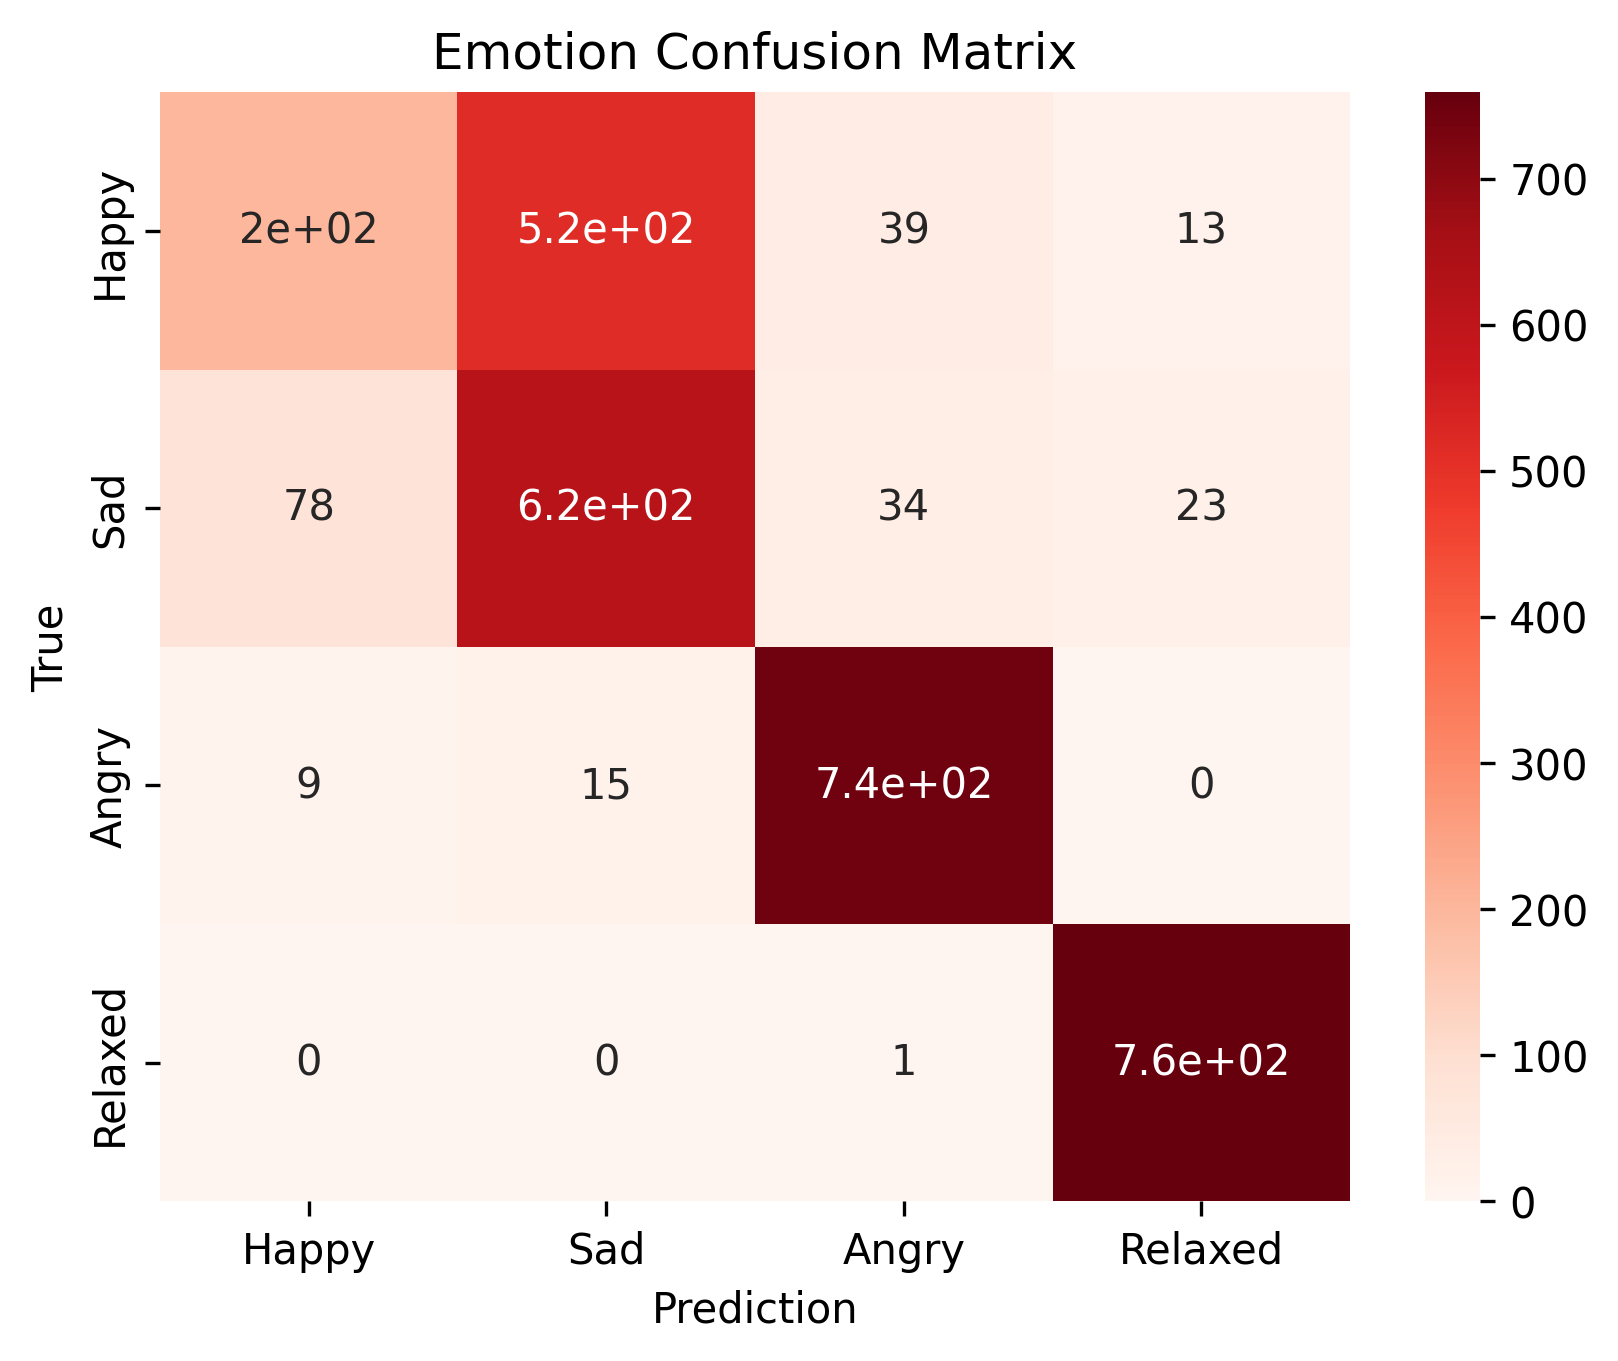

In [176]:
Y_pred = []
# Iterate through the test data in batches
for i in range(0, len(X_test), 8):
    # Get a batch of test data
    batch_X_test = X_test[i:i+8]

    # Predict on the batch
    batch_predictions = model.predict(batch_X_test)

    # Append batch predictions to the list of predictions
    Y_pred.append(batch_predictions)

# Concatenate predictions from all batches
Y_pred = np.concatenate(Y_pred)

y_pred_cat = np.zeros(len(Y_pred), dtype=int)
y_test_cat = np.zeros(len(Y_test), dtype=int)

for index, label in enumerate(Y_pred):
    y_pred_cat[index] = np.argmax(Y_pred[index])

for index, label in enumerate(Y_test):
    y_test_cat[index] = np.argmax(Y_test[index])

confusion_mat = confusion_matrix(y_test_cat, y_pred_cat)
confusion_df = pd.DataFrame(confusion_mat, index = ['Happy', 'Sad', 'Angry', 'Relaxed',], columns = ['Happy', 'Sad', 'Angry', 'Relaxed',])


figure(dpi=300)
sn.heatmap(confusion_df, annot=True, cmap=plt.cm.Reds, cbar=True)
plt.title('Emotion Confusion Matrix')
plt.xlabel("Prediction")
plt.ylabel("True")
plt.savefig("../Images/Lyrics_classification/Model1 confusion mat")
plt.show()

In [177]:
for i in y_test_cat:
    print(i)

3
2
3
0
1
1
2
2
3
3
0
3
0
1
0
2
3
2
3
0
2
2
1
3
1
0
0
1
1
1
0
0
3
1
2
0
2
1
2
3
3
1
3
3
1
2
3
2
3
1
2
0
0
0
3
1
3
0
2
1
2
2
1
1
1
0
3
0
0
0
1
0
2
3
1
3
3
1
3
3
3
2
1
1
1
1
0
1
0
1
0
3
2
1
1
0
0
1
2
3
2
3
0
3
3
3
1
0
2
2
3
2
0
0
0
2
0
2
1
3
0
1
2
1
3
2
1
1
1
0
1
3
2
1
1
1
1
1
3
3
0
2
2
0
2
3
0
2
1
3
1
1
3
1
3
0
1
2
1
2
1
1
2
2
3
2
0
3
3
0
1
2
2
1
1
2
1
2
3
0
2
3
0
1
0
3
0
2
1
3
3
0
1
0
0
0
0
0
3
0
3
0
1
1
2
2
2
2
2
0
0
2
0
0
1
2
2
3
2
2
2
2
2
0
2
2
0
3
1
2
0
3
0
1
0
1
2
1
0
3
2
1
1
3
0
1
2
2
0
1
1
0
0
1
0
2
0
2
1
2
0
3
3
3
2
2
1
3
2
2
0
3
3
1
0
3
0
3
1
3
1
3
1
3
2
0
2
1
0
0
1
0
0
0
2
0
2
2
3
1
3
2
1
0
3
0
3
2
3
2
1
2
3
3
0
1
2
2
3
0
1
1
0
3
3
2
3
2
0
0
1
2
1
1
2
2
3
3
0
0
3
3
0
0
2
1
0
2
0
1
1
1
2
1
3
2
2
3
2
2
0
1
2
1
3
1
2
2
1
2
3
1
3
3
0
3
3
3
1
0
0
3
3
1
1
2
2
2
3
3
0
2
2
3
2
3
2
0
3
3
2
0
1
3
2
2
0
1
2
2
0
0
1
3
2
0
3
2
0
3
1
0
0
3
0
1
2
0
0
0
0
1
1
0
1
2
1
3
1
1
3
3
1
2
3
0
0
3
1
0
0
1
2
1
0
2
3
3
0
3
0
0
0
3
3
3
0
3
0
0
1
3
1
0
0
0
3
3
0
2
1
1
2
1
3
2
2
0
1
0
2
1
1
1
0
2
0
3
1
3


In [145]:
# Remove jump lines and song structure text "[]"
lyrics_clean2 = []
translator2 = str.maketrans('', '', string.punctuation)


for lyric in dataset['test']['lyrics']:
    # Remove newlines and tags like [Verse], [Chorus], etc.
    cleaned_text = re.sub(r"\\n", " ", lyric)
    cleaned_text = re.sub(r"\[\w+.*?\]", "", cleaned_text)
    lyrics_clean2.append(cleaned_text)

# Separates a text into a list of tokens/words
lyrics_tokens2 = []
for lyric in lyrics_clean2:
    tokens = word_tokenize(lyric) 
    lyrics_tokens2.append(tokens)

In [146]:
lyrics_sequence2 = tokenizer1.texts_to_sequences(lyrics_tokens2) 

# Creates sparse matrix so every entry has the same dimensions
lyrics_matrix = pad_sequences(lyrics_sequence2, maxlen=highest_tokens1) 

In [147]:
highest_tokens1

173033

In [148]:
lyrics_matrix

array([[ 0,  0,  0, ...,  1, 60, 23],
       [ 0,  0,  0, ...,  1, 60, 23],
       [ 0,  0,  0, ...,  1, 60, 23],
       ...,
       [ 0,  0,  0, ...,  1, 60, 23],
       [ 0,  0,  0, ...,  1, 60, 23],
       [ 0,  0,  0, ...,  1, 60, 23]])

In [160]:
Y_pred2 = []
# Iterate through the test data in batches
for i in range(0, len(lyrics_matrix), 8):
    # Get a batch of test data
    batch_X_test = lyrics_matrix[i:i+8]

    # Predict on the batch
    batch_predictions = model.predict(batch_X_test)

    # Append batch predictions to the list of predictions
    Y_pred2.append(batch_predictions)

Y_pred2 = np.concatenate(Y_pred2)


1/1 [==============================] - 0s 21ms/step


In [162]:
for i in range(len(Y_pred2)):
    print("Real: ", dataset['test']['mood_cats'][i])
    print("Pred: ", np.argmax(Y_pred2[i]))
    print(dataset['test']['lyrics'][i][0:100])

Real:  3
Pred:  1
"Fields of Desolation LyricsOn the fields of desolation\nWe are all alone\nCrying in each others arm
Real:  2
Pred:  1
"When You Come Back To Me LyricsNow that I've found you\nThe feeling won't leave my heart\nHolding o
Real:  0
Pred:  1
"Are You Magnetic? LyricsI'm on the phone I can't say anything, in case I say the wrong thing\nAnd y
Real:  0
Pred:  1
"Into The Ocean Lyrics[Verse 1]\nI'm just a normal boy\nThat sank when I fell overboard\nMy ship wou
Real:  1
Pred:  1
'Bonfires LyricsI was given wine\nWe’re feeling okay\nAnd quite all right\nYou wash my tears away\nA
Real:  0
Pred:  1
"Make the World Go Away Lyrics[Chorus]\nMake the world go away\nAnd get it off my shoulders\nSay the
Real:  0
Pred:  1
"More Today Than Yesterday LyricsI don't remember what day it was\nI didn't notice what time it was\
Real:  0
Pred:  1
"Two Tribes LyricsYeah..\nHa!\n\nWhen two tribes go to war\nA point is all that you can score\nScore
Real:  0
Pred:  1
"Don’t Stop Looking For Love L

In [174]:
y_pred_cat = np.zeros(len(Y_pred2), dtype=int)
y_test_cat = np.zeros(len(Y_pred2), dtype=int)

for index, label in enumerate(Y_pred2):
    y_pred_cat[index] = np.argmax(Y_pred2[index])

for index, label in enumerate(dataset['test']['mood_cats']):
    y_test_cat[index] = dataset['test']['mood_cats'][index]

confusion_mat = confusion_matrix(y_test_cat, y_pred_cat)
confusion_df = pd.DataFrame(confusion_mat, index = ['Happy', 'Sad', 'Angry', 'Relaxed',], columns = ['Happy', 'Sad', 'Angry', 'Relaxed',])


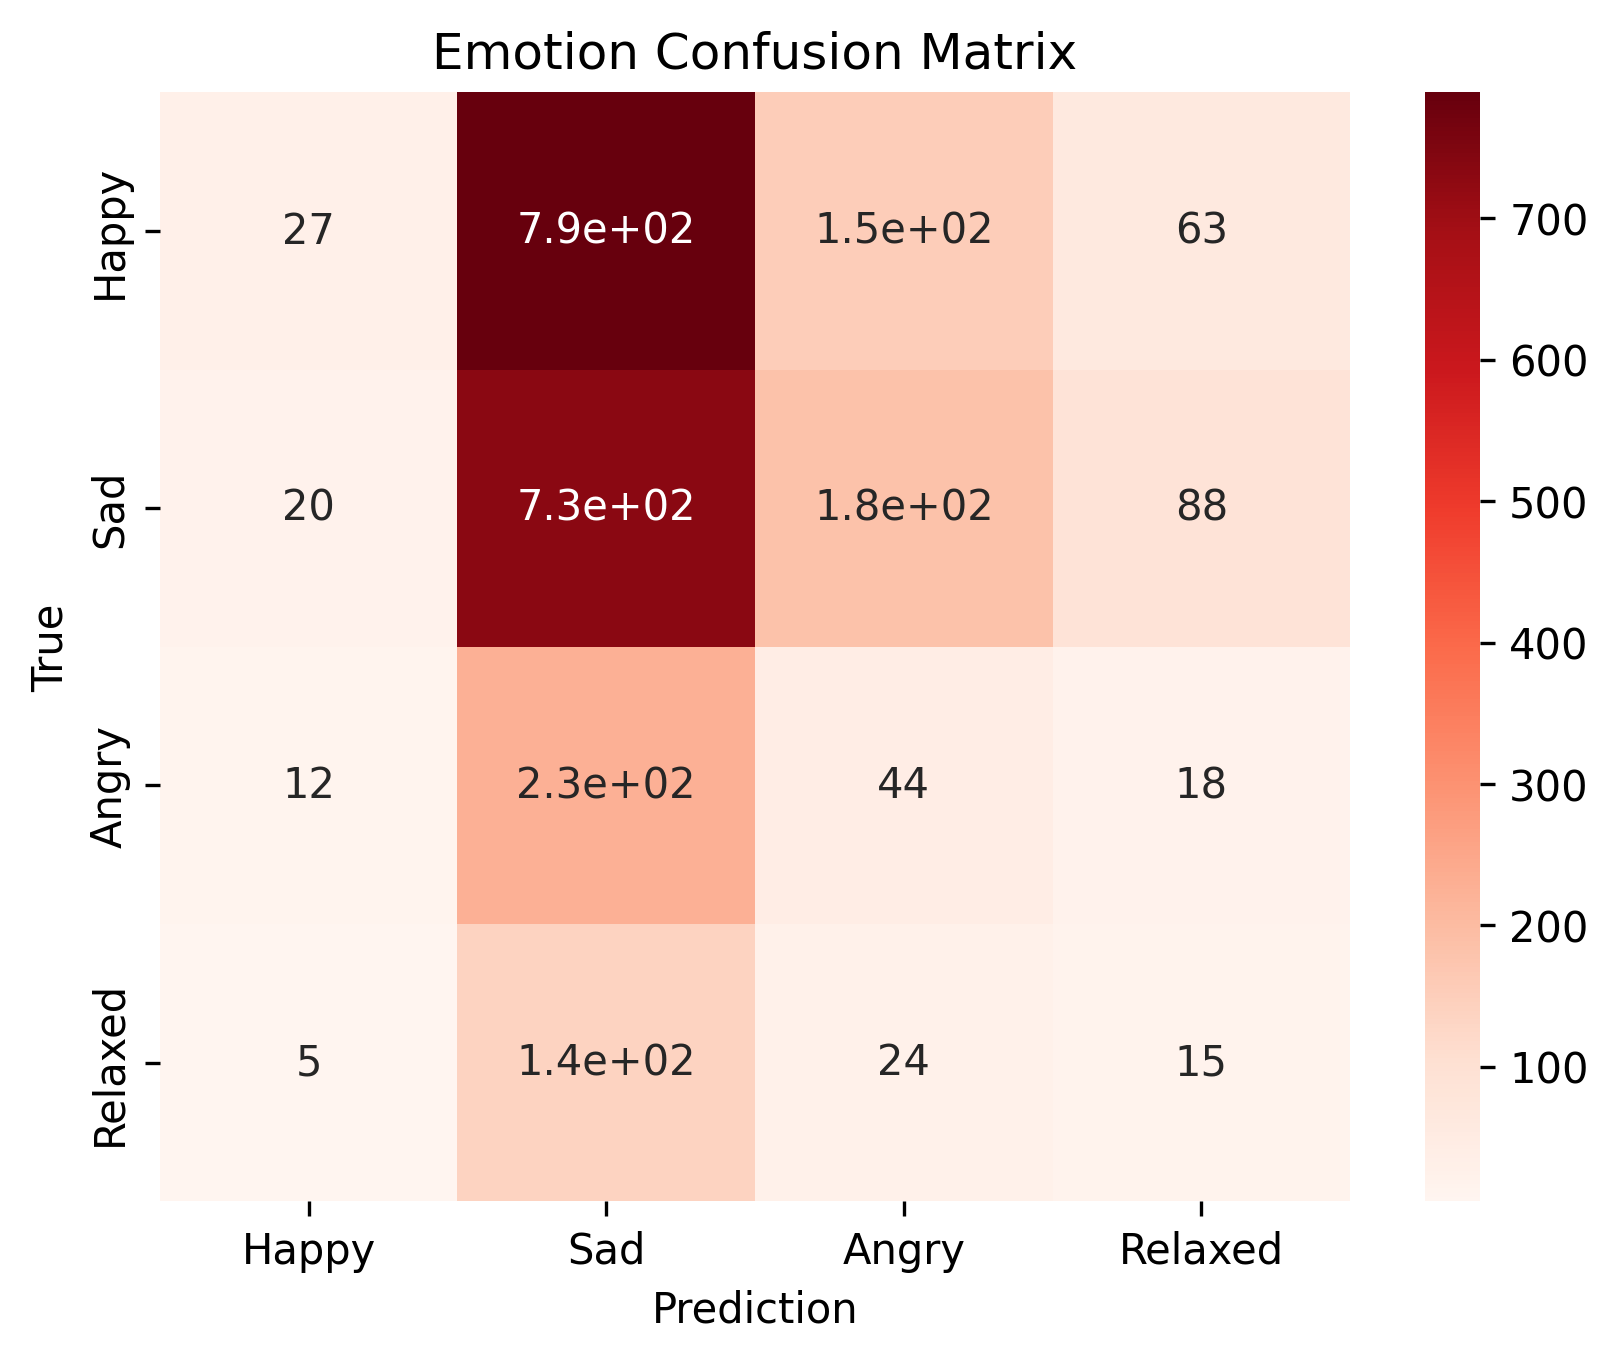

In [175]:
figure(dpi=300)
sn.heatmap(confusion_df, annot=True, cmap=plt.cm.Reds, cbar=True)
plt.title('Emotion Confusion Matrix')
plt.xlabel("Prediction")
plt.ylabel("True")
plt.show()

In [97]:
# Network 2
embedding_layer = Embedding(total_words1, 100, embeddings_initializer=Constant(train_data), input_shape=(highest_tokens1,),trainable=False)

model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.2))
model.add(Conv1D(128, 16, activation='relu'))
model.add(Conv1D(64, 8, activation='relu'))
model.add(Conv1D(32, 8, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', f1_m, precision_m, recall_m])

with tf.device(‘/gpu:0’):
    history_model = model.fit(X_train, Y_train, batch_size=16, epochs=10, validation_data=(X_test, Y_test), verbose=2)

SyntaxError: invalid character '‘' (U+2018) (1259130636.py, line 17)

In [172]:
for i in y_test_cat:
    print(i)

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [173]:
dataset['test']['mood_cats']

[3,
 2,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 2,
 1,
 3,
 0,
 1,
 1,
 0,
 3,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 2,
 0,
 2,
 2,
 2,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 3,
 0,
 0,
 1,
 1,
 2,
 2,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 2,
 2,
 1,
 2,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 2,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 3,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 2,
 1,
 2,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 2,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 3,
 1,
 1,
 1,
 0,
 0,
 2,
 3,
 0,
 0,
 1,
 1,
 0,
 3,
 0,
 2,
 3,
 0,
 0,
 1,
 2,
 3,
 2,
 2,
 0,
 1,
 2,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 2,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 2,
 1,
 1,
 0,
 2,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 2,
 2,
 1,
 2,
 1,
 1,
 3,
 3,
 0,
 0,


In [99]:
# Keras model
# Define Classification model

np.random.seed(123)

model_2 = keras.models.Sequential(name='Model_2(Preprocessing +  GloVe 100D)')

model_2.add(InputLayer(input_shape=(20,),name='Integer_Encoding_after_Preprocessing'))
model_2.add(Embedding(total_words1, 100, weights=[train_data], input_length=highest_tokens1,mask_zero=True,
                      name='Pretrained_GloVe_100D', trainable=False))
model_2.add(Bidirectional(LSTM(64,name='LSTM'),name='Bidirectional_RNN'))
model_2.add(Dropout(0.5,name='Regularizer'))
model_2.add(Dense(1, activation='sigmoid',name='Sigmoid_Classifier'))
     

# Compile the Model

model_2.compile(optimizer=keras.optimizers.adam(lr=0.001),loss='binary_crossentropy',
                metrics=['accuracy'])
     

# Model details

model_2.summary()
keras.utils.plot_model(model_2,to_file='model_2.png')

NameError: name 'keras' is not defined

In [100]:
import keras
help(keras.backend.sum)

Help on function sum in module keras.backend:

sum(x, axis=None, keepdims=False)
    Sum of the values in a tensor, alongside the specified axis.
    
    Args:
        x: A tensor or variable.
        axis: An integer, the axis to sum over.
        keepdims: A boolean, whether to keep the dimensions or not.
            If `keepdims` is `False`, the rank of the tensor is reduced
            by 1. If `keepdims` is `True`,
            the reduced dimension is retained with length 1.
    
    Returns:
        A tensor with sum of `x`.



In [ ]:
import tensorflow.keras.backend as K2
help(K2.sum)